## Pancreatic Cancer Detection

### Dataset Creation

In [2]:
from pathlib import Path
import torch
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(94)
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
import os
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from utils import Utilities as utils
from sklearn import preprocessing
from torch.utils.data import Dataset
import torch

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return torch.Tensor(sample).float() 


In [4]:
class DataFrameEntry():
    def __init__(self, columns : list, values : list, name = '') -> None:
        self.columns = columns
        self.values = values
        self.name = name

class DataFrameLabel():
    def __init__(self, columns : list, values : list, name = '') -> None:
        self.columns = columns
        self.values = values
        self.name = name


In [5]:

class Dataset(Dataset):
    def __init__(self, filePath : str, label_column : list, separator = ';', name=''):
        self.dataframe = utils.createDataframe(filepath=filePath,
                                               separator=separator)
        self.label_column = label_column
        self.encoders = {}
        self.label_dicts = {}

    def init_label_dictionary(self, label_column : str | int, label_dict : dict):
        self.label_dicts[label_column] = label_dict


    def __len__(self):
        return len(self.dataframe)

    def get_labels(self):
        return self.df[self.label_column]

    def encode_column(self, column : str | int) -> None:
        if self.encoders.get(column) is None:
            self.encoders[column] = preprocessing.LabelEncoder()
            self.encoders[column].fit(self.dataframe[column].values)
        self.dataframe[column] = self.encoders[column].transform(self.dataframe[column].values)

    def decode_column(self, column : str | int) -> None:
        if self.encoders.get(column) is not None:
            self.dataframe[column] = self.encoders[column].inverse_transform(self.dataframe[column].values)
        else:
            print('Warning: Column not encoded')

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.dataframe.iloc[idx]

    def get_column_types(self, column : str | int) -> str:
        if self.__len__() > 0:
            return type(self.dataframe[column][0])
        else:
            raise Exception('Dataset is empty')



    def addDataset(self, filePath : str, separator = ';', name='') -> None:
        self.df = utils.createDataframe(self.base_path + filePath, separator=separator)

        if self.df is None:
            print('Error: File not found or not valid')
        else:
            if self.dataframes.get(name) is None:
                self.dataframes[name] = self.df
                self.encode_df = self.df.copy()
                print('Added ' + filePath + ' to dataset')
            else:
                print('Warning: Dataset name already exists')


    def createDataset(self, files : list) -> None:
        frames = []
        for file in files:
            csv = self.base_path + file
            df = pd.read_csv(csv, sep=";")
            frames.append(df)
        self.df = pd.concat(frames)
        self.df.drop_duplicates(inplace=True)

    def get_feature_count(self):
        return len(self.dataframe.columns) - 1

    def get_label_count(self):
        return len(self.dataframe[self.label_column].unique())

    def cleanDataframe(self):
        # Check for columns with all different values
        size = self.dataframe.shape
        self.dataframe = self.dataframe.loc[:, self.dataframe.apply(pd.Series.nunique) != self.dataframe.shape[0]]

        # Exclude some entries as to make it even
        self.dataframe = self.dataframe[:self.dataframe.shape[0] - (self.dataframe.shape[0] % 10)]
        print("Removed: " + str(size[0] - self.dataframe.shape[0]) + " rows | " +
              str(size[1] - self.dataframe.shape[1]) + " columns")

    def applyPreprocessing(self, columns:list):
        size = self.df.shape[1]
        self.select(columns)
        print("Removed " + str(size - self.df.shape[1]) + " columns")

    def select(self, columns:list):
        if self.deleted is None:
            self.deleted = pd.DataFrame()

        # Restore the deleted columns
        # self.restore(columns)

        # Keep track of the deleted columns
        _deletedColumns = self.df.columns.difference(columns)

        if self.deleted.empty:
            self.deleted = self.df[_deletedColumns]
        else:
            self.deleted = pd.concat([self.deleted, self.df[_deletedColumns]], axis=0)


        self.df.drop(_deletedColumns, axis=1, inplace=True)

    
    def restore(self, columns : list):
        restored = 0
        if self.deleted is None or self.deleted.empty:
            print("No columns to restore")
            return
        else:
            for col in (set(self.deleted.columns) & set(columns)):
                restored += 1
                _restored = self.deleted[col]

                self.df = pd.concat([self.df, _restored], axis=1, ignore_index=True)
                print(self.df.columns)
                # self.df.append(self.deleted[col])
        print("Restored " + str(restored) + " columns")


    def applyFilter(self, column, value, maxrows=None, criterion='equal'):
        if maxrows is not None:
            self.df = self.df.head(maxrows)
        if criterion == 'equal':
            self.df = self.df[self.df[column] == value]
        elif criterion == 'contains':
            self.df = self.df[self.df[column].str.contains(value)]

    def colSize(self):
        return len(self.df.columns)

    def rowSize(self):
        return len(self.df.index)



In [6]:
urinary_data = Dataset(filePath='../data/urinary_data.csv',
                       label_column='diagnosis',
                       separator=',',
                       name='urinary_data')
display(urinary_data.dataframe.head())



,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


### Dataset cleaning and preparation

In [7]:
# urinary_data.cleanDataframe()
# Encode labels
for column in urinary_data.dataframe.columns:
    urinary_data.encode_column(column)

display(urinary_data.dataframe.head())

# Dataset Cleaning
urinary_data.cleanDataframe()

display(urinary_data.dataframe.head())


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,0,0,0,6,0,0,8,52,78,158,181,337,391,247
1,1,0,0,54,0,0,8,52,266,93,265,402,242,151
2,2,1,0,24,1,0,8,52,62,75,108,412,347,298
3,3,1,0,34,1,0,8,52,67,68,47,351,209,298
4,4,1,0,35,1,0,8,52,70,16,14,360,117,298


Removed: 0 rows | 1 columns


,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,0,0,6,0,0,8,52,78,158,181,337,391,247
1,0,0,54,0,0,8,52,266,93,265,402,242,151
2,1,0,24,1,0,8,52,62,75,108,412,347,298
3,1,0,34,1,0,8,52,67,68,47,351,209,298
4,1,0,35,1,0,8,52,70,16,14,360,117,298


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Dataset split
X = urinary_data.dataframe.iloc[:, urinary_data.dataframe.columns != urinary_data.label_column].squeeze()
y = urinary_data.dataframe[urinary_data.label_column].values.reshape(-1, 1).squeeze()


print(f"Type = {type(X.values)}")
print(f"Shape = {X.shape}")
print(f"Type = {type(y)}")
print(f"Shape = {y.shape}")

# Convert to tensors
X = torch.from_numpy(X.values).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

print(f"Type = {type(X)}")
print(f"Shape = {X.shape}")
print(f"Type = {type(y)}")
print(f"Shape = {y.shape}")

# Send to GPU
X = X.to(device)
y = y.to(device)

Type = <class 'numpy.ndarray'>
Shape = (590, 12)
Type = <class 'numpy.ndarray'>
Shape = (590,)
Type = <class 'torch.Tensor'>
Shape = torch.Size([590, 12])
Type = <class 'torch.Tensor'>
Shape = torch.Size([590])


In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.to(device)
X_val.to(device)
X_test.to(device)
y_train.to(device)
y_val.to(device)
y_test.to(device)

print("Set sizes: Train: {}, Validation: {}, Test: {}".format(len(X_train), len(X_val), len(X_test)))
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))



Set sizes: Train: 377, Validation: 95, Test: 118
X_train shape: torch.Size([377, 12])
y_train shape: torch.Size([377])
X_val shape: torch.Size([95, 12])
y_val shape: torch.Size([95])
X_test shape: torch.Size([118, 12])
y_test shape: torch.Size([118])


###

### Model Definition


In [10]:
from models import PCDModel_1, BlobModel


model_0 = PCDModel_1(urinary_data.get_feature_count(), urinary_data.get_label_count()).to(device)
print(model_0.state_dict)

# Predicted logits
pred_logits = model_0(X_train.to(device))[:10]
display(pred_logits)

# Predicted probabilities
pred_prob = torch.softmax(pred_logits, dim=1)
display(pred_prob)

# Predicted classes
pred_classes = torch.argmax(pred_prob, dim=1)
display(pred_classes)



<bound method Module.state_dict of PCDModel_1(
  (linearBlock): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)>


tensor([[ -283.6411,  2320.2124, -4321.7505],
        [  -77.7950,    61.5888,  -418.1554],
        [ -105.8213,   701.6616, -1393.0272],
        [ -214.2239,  1167.0740, -2033.0388],
        [ -245.0206,  1271.3246, -3184.8486],
        [  -80.9450,  1219.4695, -2614.6204],
        [ -208.2206,  1118.8560, -2225.1404],
        [  -46.2048,   768.9744,  -509.6219],
        [ -118.2406,   749.9640, -1883.3269],
        [ -137.8341,  1170.8188, -2459.0908]], device='cuda:0',
       grad_fn=<SliceBackward0>)

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

### Model Training

In [11]:
# Define loss function
# Binary classification => BCELoss
from models import train_binary_logits

from models import MulticlassClassification
from models import accuracy_fn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
# TRAINING
epochs = 10000

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=1E-6, momentum=0.9)

losses = []
for epoch in range(epochs):
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train.to(device)).to(device)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #print(y_pred.shape)
    # 2. Compute loss
    loss = loss_fn(y_logits, y_train)
    losses.append(loss)

    # 2.1 Compute accuracy
    acc = accuracy_fn(y_train, y_pred)

    # 3. Optimizer zero_grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    # 6. Test
    model_0.eval()
    with torch.inference_mode():
        # 6.1 Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_prob= torch.softmax(test_logits, dim = 1)
        test_pred = torch.argmax(test_prob, dim = 1)
        # 6.2 Compute loss
        test_loss = loss_fn(test_logits, y_test)
        # 6.3 Compute accuracy
        test_acc = accuracy_fn(y_test, test_pred)
    if epoch % 1 == 0:
        print("Epoch: {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}".format(epoch, loss, acc, test_loss, test_acc))





Epoch: 0, Loss: 2110.980712890625, Accuracy: 36.07426834106445, Test Loss: 2037.3232421875, Test Accuracy: 33.050846099853516
Epoch: 1, Loss: 2084.410888671875, Accuracy: 36.07426834106445, Test Loss: 1987.1661376953125, Test Accuracy: 33.050846099853516
Epoch: 2, Loss: 2034.218505859375, Accuracy: 36.07426834106445, Test Loss: 1916.2852783203125, Test Accuracy: 33.050846099853516
Epoch: 3, Loss: 1963.2847900390625, Accuracy: 36.07426834106445, Test Loss: 1827.444091796875, Test Accuracy: 33.050846099853516
Epoch: 4, Loss: 1874.3736572265625, Accuracy: 36.07426834106445, Test Loss: 1723.24853515625, Test Accuracy: 33.050846099853516
Epoch: 5, Loss: 1770.08984375, Accuracy: 36.07426834106445, Test Loss: 1606.1134033203125, Test Accuracy: 33.050846099853516
Epoch: 6, Loss: 1652.9149169921875, Accuracy: 35.80902099609375, Test Loss: 1478.26123046875, Test Accuracy: 33.050846099853516
Epoch: 7, Loss: 1525.0355224609375, Accuracy: 36.07426834106445, Test Loss: 1341.8369140625, Test Accuracy

In [12]:
pred = model_0(X_test[10]).squeeze()
print(y_test[10])
print(pred)

tensor(2, device='cuda:0')
tensor([35.2912, 35.6784, 39.5669], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


### Model Evaluation

In [13]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

In [14]:
# Model evaluation
model_0.eval()

PCDModel_1(
  (linearBlock): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [15]:
# Compute F1 score
f1 = calculate_f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy())
print("F1 Score: ", f1)

F1 Score:  0.9164251641091669


In [16]:
from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(y_test.cpu().numpy(), test_pred.cpu().numpy())
print("Accuracy: ", accuracy)

Accuracy:  0.9152542372881356


In [17]:
from sklearn.metrics import precision_score, recall_score

# Compute precision
precision = precision_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
print("Precision: ", precision)

# Compute recall
recall = recall_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
print("Recall: ", recall)

Precision:  0.92247651675167
Recall:  0.9152542372881356


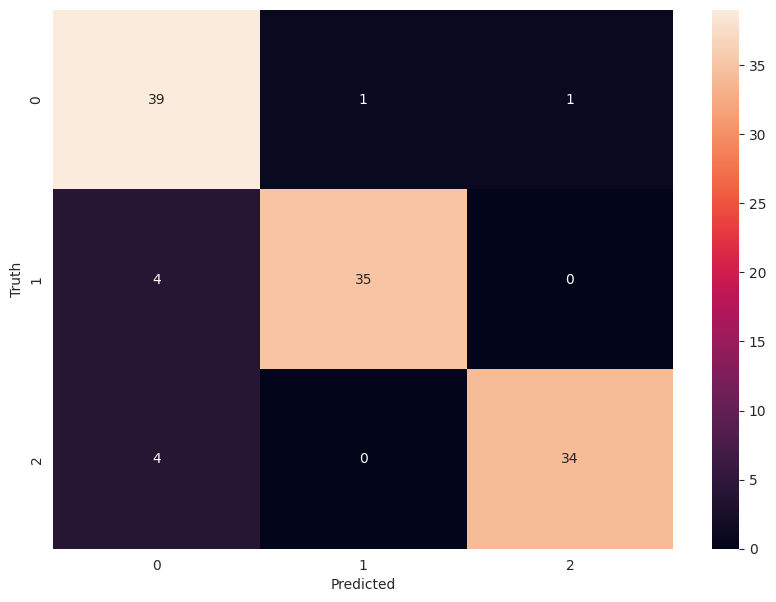

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test.cpu().numpy(), test_pred.cpu().numpy())

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()